In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

In [2]:
keras.utils.set_random_seed(21)

Загрузим и подготовим данные

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [4]:
len(X_train), len(X_test)

(50000, 10000)

In [5]:
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, 
                                                    test_size=0.2, random_state=21)

In [6]:
X_train = X_train/255
X_test = X_test/255
X_valid = X_valid/255

# Предобучение feature extracor

In [7]:
'''
Случайным образом выбираем две четвертинки изображения 
и сохраняем позицию второй части для последующего обучения
'''
def load_imgs(imgs):
    inputs_first = []
    inputs_second = []
    outputs = []
    sec_coords = [[[0, 32],[0, 32]], [[0, 32],[32, 64]], 
                  [[32, 64],[0, 32]], [[32, 64],[32, 64]]]
    for img in imgs:
        sect = [0, 1, 2, 3]
        img = tf.image.resize(img,[32*2, 32*2])
        sect1 = sect[np.random.randint(0, len(sect))]
        sect.pop(sect1)
        sect2 = sect[np.random.randint(0, len(sect))]
        first_img = img[sec_coords[sect1][0][0]:sec_coords[sect1][0][1], 
                        sec_coords[sect1][1][0]:sec_coords[sect1][1][1]]
        second_img = img[sec_coords[sect2][0][0]:sec_coords[sect2][0][1], 
                        sec_coords[sect2][1][0]:sec_coords[sect2][1][1]]
        inputs_first.append(first_img)
        inputs_second.append(second_img)
        outputs.append(sect2)
    
    return np.asarray(inputs_first), np.asarray(inputs_second), keras.utils.to_categorical(outputs, 4)

Предобучим бэкбон на всем датасете, затем обучим модель на 100% данных

In [8]:
train_first, train_second, train_outputs = load_imgs(X_train)
valid_first, valid_second, valid_outputs = load_imgs(X_test)

Metal device set to: Apple M1


In [9]:
len(train_first), len(train_second), len(train_outputs)

(50000, 50000, 50000)

In [10]:
train_first.shape

(50000, 32, 32, 3)

In [7]:
#backbone
inputs = keras.Input(shape = (32,32,3))
x=keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x=keras.layers.MaxPooling2D((2, 2), strides=2)(x)
x=keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x=keras.layers.MaxPooling2D((2, 2), strides=2)(x)
x=keras.layers.Dropout(0.3)(x)
x=keras.layers.Conv2D(128, (2, 2), padding='same', activation='relu')(x)
outputs=keras.layers.MaxPooling2D((2, 2), strides=1)(x)

backbone = keras.models.Model(inputs = inputs, outputs=outputs)
backbone.summary()

Metal device set to: Apple M1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (N

In [8]:
backbone.weights

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 32) dtype=float32, numpy=
 array([[[[-0.02075759, -0.07907808,  0.07201627,  0.00219887,
            0.10192454,  0.09929521,  0.01023628, -0.03949883,
            0.12384279, -0.07144642, -0.12995194, -0.08599012,
            0.10514912, -0.1039504 , -0.00617266,  0.04004778,
            0.10700825, -0.00914496, -0.05066461,  0.0418233 ,
            0.03079835, -0.08881099, -0.11214016,  0.10642807,
           -0.04492584, -0.06144531,  0.01391101,  0.05443999,
            0.00042249,  0.01446542,  0.13497682, -0.12072751],
          [ 0.09176101,  0.00664419,  0.05880018, -0.13574797,
           -0.0933516 ,  0.08685887, -0.09921403,  0.04677255,
            0.13444458,  0.12349702, -0.02040324, -0.07319535,
           -0.01051439,  0.05504689, -0.11775887,  0.09746528,
            0.04852468,  0.08343907, -0.06488614,  0.03208721,
           -0.08343689, -0.12312332,  0.10839535, -0.0180511 ,
           -0.10089123,  0.11603995, -0.043

In [9]:
#SSL model
inputs1 = keras.Input(shape = (32,32,3), name='first_img')
inputs2 = keras.Input(shape = (32,32,3), name='second_img')
backbone1 = backbone(inputs1)
backbone2 = backbone(inputs2)
inputs = keras.layers.Concatenate()([backbone1, backbone2])
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(512, activation='relu')(x)
outputs = keras.layers.Dense(4, activation='softmax', name='Output')(x)

ssl_model = keras.models.Model(inputs = [inputs1, inputs2], outputs = outputs)
ssl_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 first_img (InputLayer)      [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 second_img (InputLayer)     [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 model (Functional)          (None, 7, 7, 128)            52288     ['first_img[0][0]',           
                                                                     'second_img[0][0]']          
                                                                                                  
 concatenate (Concatenate)   (None, 7, 7, 256)            0         ['model[0][0]',         

In [14]:
ssl_model.compile(keras.optimizers.legacy.Adam(0.0005), loss="categorical_crossentropy",
              metrics=[keras.metrics.F1Score(average = 'weighted'), keras.metrics.Precision(), keras.metrics.Recall()])

In [15]:
ssl_model.fit({'first_img':train_first, 'second_img':train_second},  train_outputs, 
          validation_data=({'first_img':valid_first, 'second_img':valid_second},  valid_outputs),
          batch_size=256, epochs=25)

Epoch 1/25
196/196 [==============================] - 20s 101ms/step - loss: 1.1576 - f1_score: 0.4646 - precision: 0.6698 - recall: 0.2209 - val_loss: 0.9108 - val_f1_score: 0.6303 - val_precision: 0.7417 - val_recall: 0.4825
Epoch 2/25
196/196 [==============================] - 20s 99ms/step - loss: 0.8034 - f1_score: 0.6745 - precision: 0.7530 - recall: 0.5767 - val_loss: 0.7118 - val_f1_score: 0.7214 - val_precision: 0.8141 - val_recall: 0.6285
Epoch 3/25
196/196 [==============================] - 19s 96ms/step - loss: 0.7005 - f1_score: 0.7224 - precision: 0.7866 - recall: 0.6481 - val_loss: 0.6546 - val_f1_score: 0.7423 - val_precision: 0.8038 - val_recall: 0.6760
Epoch 4/25
196/196 [==============================] - 19s 97ms/step - loss: 0.6381 - f1_score: 0.7498 - precision: 0.8061 - recall: 0.6853 - val_loss: 0.6293 - val_f1_score: 0.7492 - val_precision: 0.8147 - val_recall: 0.6770
Epoch 5/25
196/196 [==============================] - 20s 100ms/step - loss: 0.5816 - f1_score:

In [17]:
#сохраним веса для нашего feature extracor
backbone.save_weights('../Weights/backbone')
backbone.weights


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 32) dtype=float32, numpy=
 array([[[[-3.21784541e-02, -5.65008931e-02,  8.69211480e-02,
            1.41900685e-02,  1.21502034e-01,  3.34839299e-02,
            2.43771020e-02, -6.43562376e-02,  1.12775296e-01,
           -9.95760784e-02, -2.61960477e-01, -9.18506384e-02,
            1.42031133e-01, -7.35143200e-02, -2.07712017e-02,
            3.37416232e-02,  1.31594077e-01,  5.72979869e-03,
           -5.06646112e-02,  2.37167031e-02,  3.98697406e-02,
           -1.38369247e-01, -1.05120584e-01,  1.51110113e-01,
           -4.01232652e-02, -6.15901090e-02,  2.08195671e-03,
            8.02023113e-02, -3.96554284e-02,  9.89580713e-03,
            1.15381680e-01, -1.26767650e-01],
          [ 1.13330647e-01,  3.63745056e-02,  7.82887489e-02,
           -1.42020985e-01, -7.61158764e-02,  8.85690376e-03,
           -6.25455752e-02,  3.36933546e-02,  1.50954321e-01,
            1.18205003e-01, -1.80235922e-01, -7.79197589e-02,
            

# Подготовим датасет для обучения

In [10]:
#Подготовим данные для обучения
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)

In [11]:
X_dataset_train = tf.data.Dataset.from_tensor_slices(X_train)
y_dataset_train = tf.data.Dataset.from_tensor_slices(y_train)

dataset_train = tf.data.Dataset.zip((X_dataset_train, y_dataset_train))

In [12]:
X_dataset_valid = tf.data.Dataset.from_tensor_slices(X_valid)
y_dataset_valid = tf.data.Dataset.from_tensor_slices(y_valid)

dataset_valid = tf.data.Dataset.zip((X_dataset_valid, y_dataset_valid))

In [13]:
dataset_train = dataset_train.shuffle(500).batch(256).prefetch(tf.data.experimental.AUTOTUNE)
dataset_valid = dataset_valid.shuffle(500).batch(256).prefetch(tf.data.experimental.AUTOTUNE)

In [14]:
X_dataset_test = tf.data.Dataset.from_tensor_slices(X_test)
y_dataset_test = tf.data.Dataset.from_tensor_slices(y_test)

dataset_test = tf.data.Dataset.zip((X_dataset_test, y_dataset_test))
dataset_test = dataset_test.shuffle(500).batch(256).prefetch(tf.data.experimental.AUTOTUNE)

# Exp 1

Предобученный feature extractor и обучение на всем датасете

In [15]:
#Загрузим веса для бэкбона
backbone.load_weights('../Weights/backbone')
backbone.weights

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 32) dtype=float32, numpy=
 array([[[[-3.21784541e-02, -5.65008931e-02,  8.69211480e-02,
            1.41900685e-02,  1.21502034e-01,  3.34839299e-02,
            2.43771020e-02, -6.43562376e-02,  1.12775296e-01,
           -9.95760784e-02, -2.61960477e-01, -9.18506384e-02,
            1.42031133e-01, -7.35143200e-02, -2.07712017e-02,
            3.37416232e-02,  1.31594077e-01,  5.72979869e-03,
           -5.06646112e-02,  2.37167031e-02,  3.98697406e-02,
           -1.38369247e-01, -1.05120584e-01,  1.51110113e-01,
           -4.01232652e-02, -6.15901090e-02,  2.08195671e-03,
            8.02023113e-02, -3.96554284e-02,  9.89580713e-03,
            1.15381680e-01, -1.26767650e-01],
          [ 1.13330647e-01,  3.63745056e-02,  7.82887489e-02,
           -1.42020985e-01, -7.61158764e-02,  8.85690376e-03,
           -6.25455752e-02,  3.36933546e-02,  1.50954321e-01,
            1.18205003e-01, -1.80235922e-01, -7.79197589e-02,
            

In [16]:
#Зададим наш классификатор
inputs = keras.Input(shape = (32,32,3))
x=backbone(inputs)
x=keras.layers.Flatten()(x)
x=keras.layers.Dense(1024, activation="relu", name='Dense_1')(x)
x=keras.layers.Dropout(0.3)(x)
x=keras.layers.Dense(2046, activation='relu', name='Dense_2')(x)
x=keras.layers.Dense(512, activation='relu', name='Dense_3')(x)
x=keras.layers.Dense(256, activation='relu', name='Dense_4')(x)
output=keras.layers.Dense(10, activation='softmax', name='Output')(x)

exp_1_model = keras.models.Model(inputs = inputs, outputs = output)
exp_1_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 model (Functional)          (None, 7, 7, 128)         52288     
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 Dense_1 (Dense)             (None, 1024)              6423552   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 Dense_2 (Dense)             (None, 2046)              2097150   
                                                                 
 Dense_3 (Dense)             (None, 512)               1048

In [17]:
exp_1_model.compile(keras.optimizers.legacy.Adam(0.0005), loss="categorical_crossentropy",
              metrics=[keras.metrics.F1Score(average = 'weighted'), 
                       keras.metrics.Precision(name='precision_1'), 
                       keras.metrics.Recall(name='recall_1')])

In [18]:
learn_rate_red=keras.callbacks.ReduceLROnPlateau("val_loss", patience=3, factor = 0.5, min_lr=1e-6)
early_stop = keras.callbacks.EarlyStopping("val_loss", patience=6)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="../logs/Exp_1")

In [19]:
%%time
history_1 = exp_1_model.fit(dataset_train, validation_data=dataset_valid, 
                    epochs=50, callbacks=[learn_rate_red, early_stop, tensorboard])

Epoch 1/50
196/196 [==============================] - 13s 63ms/step - loss: 1.4432 - f1_score: 0.4717 - precision_1: 0.6958 - recall_1: 0.2760 - val_loss: 1.1328 - val_f1_score: 0.5947 - val_precision_1: 0.7810 - val_recall_1: 0.4016 - lr: 5.0000e-04
Epoch 2/50
196/196 [==============================] - 12s 61ms/step - loss: 1.0677 - f1_score: 0.6176 - precision_1: 0.7534 - recall_1: 0.4792 - val_loss: 0.9773 - val_f1_score: 0.6602 - val_precision_1: 0.7951 - val_recall_1: 0.5123 - lr: 5.0000e-04
Epoch 3/50
196/196 [==============================] - 12s 61ms/step - loss: 0.9113 - f1_score: 0.6767 - precision_1: 0.7873 - recall_1: 0.5684 - val_loss: 0.8921 - val_f1_score: 0.6855 - val_precision_1: 0.7992 - val_recall_1: 0.5775 - lr: 5.0000e-04
Epoch 4/50
196/196 [==============================] - 12s 60ms/step - loss: 0.8083 - f1_score: 0.7144 - precision_1: 0.8079 - recall_1: 0.6222 - val_loss: 0.8290 - val_f1_score: 0.7117 - val_precision_1: 0.7933 - val_recall_1: 0.6326 - lr: 5.0000e

In [20]:
eval_hist_1 = exp_1_model.evaluate(dataset_test)

8/8 [==============================] - 0s 27ms/step - loss: 0.8204 - f1_score: 0.7877 - precision_1: 0.8080 - recall_1: 0.7805


In [21]:
print("Eval_loss = {} \nEval_f1 = {} \nEval_precision = {} \nEval_recall = {}".format(eval_hist_1[0], 
                                                                                      eval_hist_1[1], 
                                                                                      eval_hist_1[2],
                                                                                      eval_hist_1[3]))

Eval_loss = 0.8203914165496826 
Eval_f1 = 0.7876771688461304 
Eval_precision = 0.8079710006713867 
Eval_recall = 0.780500054359436


<Axes: >

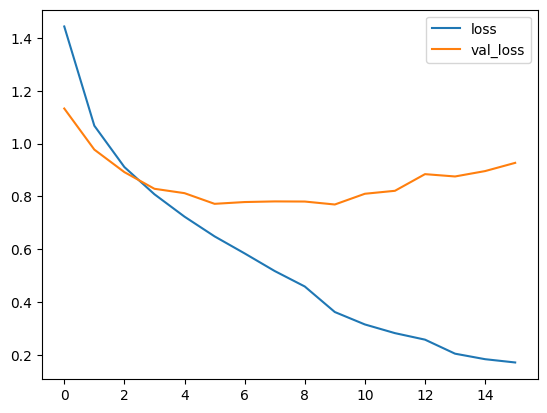

In [22]:
#График изменения функции потерь
history_df = pd.DataFrame(history_1.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

<Axes: >

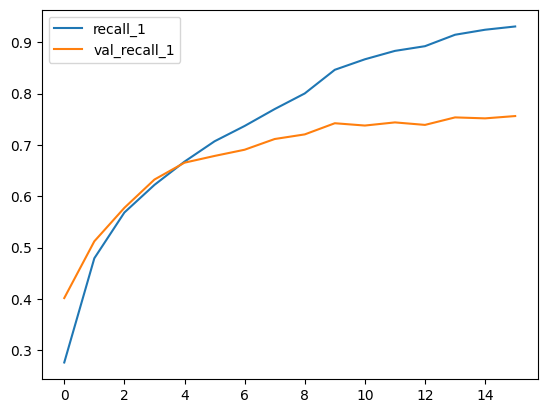

In [23]:
history_df.loc[:, ['recall_1', 'val_recall_1']].plot()

<Axes: >

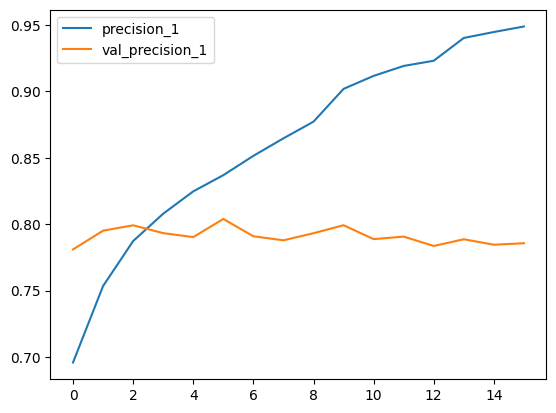

In [24]:
history_df.loc[:, ['precision_1', 'val_precision_1']].plot()

<Axes: >

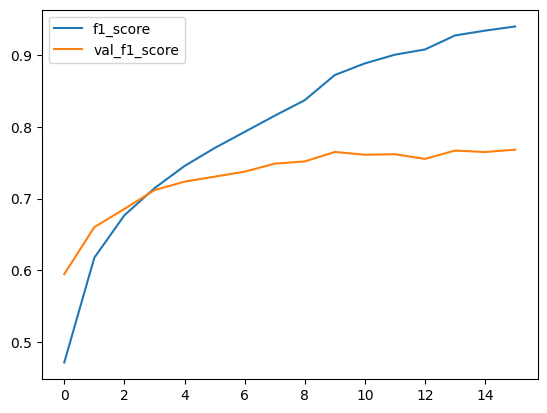

In [25]:
history_df.loc[:, ['f1_score', 'val_f1_score']].plot()

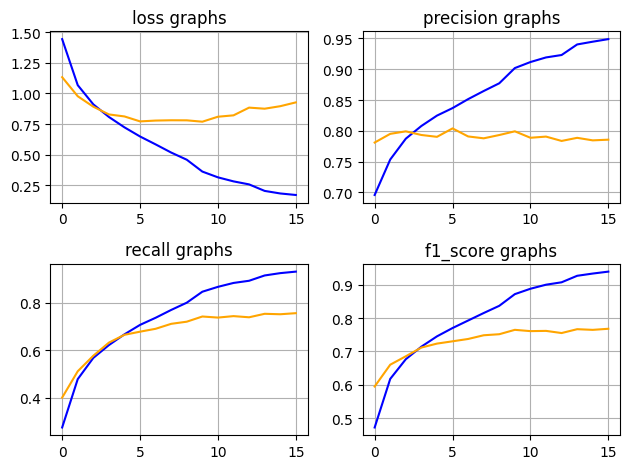

In [26]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(history_df['loss'], color='blue')
axs[0, 0].plot(history_df['val_loss'], color='orange')
axs[0, 0].set_title('loss graphs')
axs[0, 0].grid()
axs[0, 1].plot(history_df['precision_1'], color='blue')
axs[0, 1].plot(history_df['val_precision_1'], color='orange')
axs[0, 1].set_title('precision graphs')
axs[0, 1].grid()
axs[1, 0].plot(history_df['recall_1'], color='blue')
axs[1, 0].plot(history_df['val_recall_1'], color='orange')
axs[1, 0].set_title('recall graphs')
axs[1, 0].grid()
axs[1, 1].plot(history_df['f1_score'], color='blue')
axs[1, 1].plot(history_df['val_f1_score'], color='orange')
axs[1, 1].set_title('f1_score graphs')
axs[1, 1].grid()
fig.tight_layout()
plt.show()

In [27]:
preds = exp_1_model.predict(X_test)
preds = np.argmax(preds, axis=1)
y_test_idx = np.argmax(y_test, axis=1)

63/63 [==============================] - 1s 7ms/step


In [28]:
print(classification_report(y_test_idx, preds))

              precision    recall  f1-score   support

           0       0.90      0.78      0.84       208
           1       0.88      0.84      0.86       189
           2       0.74      0.66      0.70       199
           3       0.65      0.66      0.66       208
           4       0.75      0.75      0.75       196
           5       0.66      0.73      0.69       202
           6       0.81      0.86      0.84       214
           7       0.87      0.86      0.86       199
           8       0.84      0.89      0.86       194
           9       0.80      0.85      0.83       191

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000



Метрики из hw_1
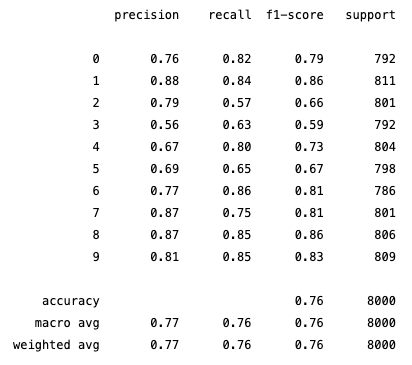

Заключение: Модель обучилась на несколько эпох быстрее при этом сохоранив значения метрик из hw_1 и даже превзойдя их (незначительно)

# Exp 2

Проведем эксперимент с предобученным бэкбоном и 50% датасетом

In [30]:
dataset_train_2 = dataset_train.shard(num_shards=2, index=0)

In [31]:
len(dataset_train_2)*256

25088

In [32]:
backbone.load_weights('../Weights/backbone')
backbone.weights

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 32) dtype=float32, numpy=
 array([[[[-3.21784541e-02, -5.65008931e-02,  8.69211480e-02,
            1.41900685e-02,  1.21502034e-01,  3.34839299e-02,
            2.43771020e-02, -6.43562376e-02,  1.12775296e-01,
           -9.95760784e-02, -2.61960477e-01, -9.18506384e-02,
            1.42031133e-01, -7.35143200e-02, -2.07712017e-02,
            3.37416232e-02,  1.31594077e-01,  5.72979869e-03,
           -5.06646112e-02,  2.37167031e-02,  3.98697406e-02,
           -1.38369247e-01, -1.05120584e-01,  1.51110113e-01,
           -4.01232652e-02, -6.15901090e-02,  2.08195671e-03,
            8.02023113e-02, -3.96554284e-02,  9.89580713e-03,
            1.15381680e-01, -1.26767650e-01],
          [ 1.13330647e-01,  3.63745056e-02,  7.82887489e-02,
           -1.42020985e-01, -7.61158764e-02,  8.85690376e-03,
           -6.25455752e-02,  3.36933546e-02,  1.50954321e-01,
            1.18205003e-01, -1.80235922e-01, -7.79197589e-02,
            

In [33]:
#Зададим наш классификатор
inputs = keras.Input(shape = (32,32,3))
x=backbone(inputs)
x=keras.layers.Flatten()(x)
x=keras.layers.Dense(1024, activation="relu", name='Dense_1')(x)
x=keras.layers.Dropout(0.3)(x)
x=keras.layers.Dense(2046, activation='relu', name='Dense_2')(x)
x=keras.layers.Dense(512, activation='relu', name='Dense_3')(x)
x=keras.layers.Dense(256, activation='relu', name='Dense_4')(x)
output=keras.layers.Dense(10, activation='softmax', name='Output')(x)

exp_2_model = keras.models.Model(inputs = inputs, outputs = output)
exp_2_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 model (Functional)          (None, 7, 7, 128)         52288     
                                                                 
 flatten_2 (Flatten)         (None, 6272)              0         
                                                                 
 Dense_1 (Dense)             (None, 1024)              6423552   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 Dense_2 (Dense)             (None, 2046)              2097150   
                                                                 
 Dense_3 (Dense)             (None, 512)               1048

In [34]:
exp_2_model.compile(keras.optimizers.legacy.Adam(0.0005), loss="categorical_crossentropy",
              metrics=[keras.metrics.F1Score(average = 'weighted'), 
                       keras.metrics.Precision(name='precision_2'), 
                       keras.metrics.Recall(name='recall_2')])

In [35]:
learn_rate_red=keras.callbacks.ReduceLROnPlateau("val_loss", patience=3, factor = 0.5, min_lr=1e-6)
early_stop = keras.callbacks.EarlyStopping("val_loss", patience=6)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="../logs/Exp_2")

In [36]:
%%time
history_2 = exp_2_model.fit(dataset_train_2, validation_data=dataset_valid, 
                    epochs=50, callbacks=[learn_rate_red, early_stop, tensorboard])

Epoch 1/50
98/98 [==============================] - 8s 80ms/step - loss: 1.6324 - f1_score: 0.3956 - precision_2: 0.6442 - recall_2: 0.1768 - val_loss: 1.2883 - val_f1_score: 0.5266 - val_precision_2: 0.7229 - val_recall_2: 0.3183 - lr: 5.0000e-04
Epoch 2/50
98/98 [==============================] - 9s 87ms/step - loss: 1.2447 - f1_score: 0.5493 - precision_2: 0.7126 - recall_2: 0.3772 - val_loss: 1.1516 - val_f1_score: 0.5841 - val_precision_2: 0.7562 - val_recall_2: 0.4153 - lr: 5.0000e-04
Epoch 3/50
98/98 [==============================] - 9s 88ms/step - loss: 1.0959 - f1_score: 0.6047 - precision_2: 0.7457 - recall_2: 0.4605 - val_loss: 1.0250 - val_f1_score: 0.6313 - val_precision_2: 0.7773 - val_recall_2: 0.4934 - lr: 5.0000e-04
Epoch 4/50
98/98 [==============================] - 9s 92ms/step - loss: 0.9978 - f1_score: 0.6457 - precision_2: 0.7702 - recall_2: 0.5205 - val_loss: 0.9656 - val_f1_score: 0.6576 - val_precision_2: 0.7647 - val_recall_2: 0.5578 - lr: 5.0000e-04
Epoch 5/

In [37]:
eval_hist_2 = exp_2_model.evaluate(dataset_test)

8/8 [==============================] - 0s 31ms/step - loss: 0.7234 - f1_score: 0.7738 - precision_2: 0.8069 - recall_2: 0.7480


In [38]:
print("Eval_loss = {} \nEval_f1 = {} \nEval_precision = {} \nEval_recall = {}".format(eval_hist_2[0], 
                                                                                      eval_hist_2[1], 
                                                                                      eval_hist_2[2],
                                                                                      eval_hist_2[3]))

Eval_loss = 0.7234111428260803 
Eval_f1 = 0.7738285660743713 
Eval_precision = 0.8069040179252625 
Eval_recall = 0.7480000257492065


<Axes: >

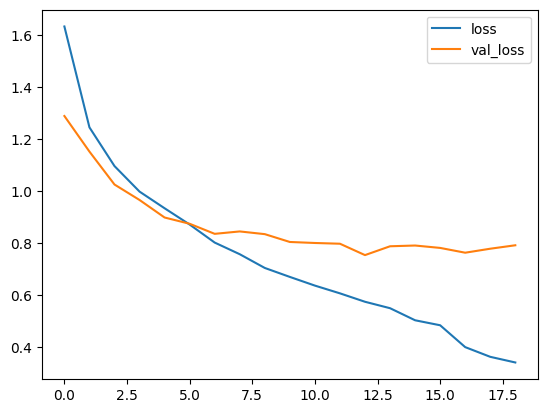

In [39]:
#График изменения функции потерь
history_df = pd.DataFrame(history_2.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

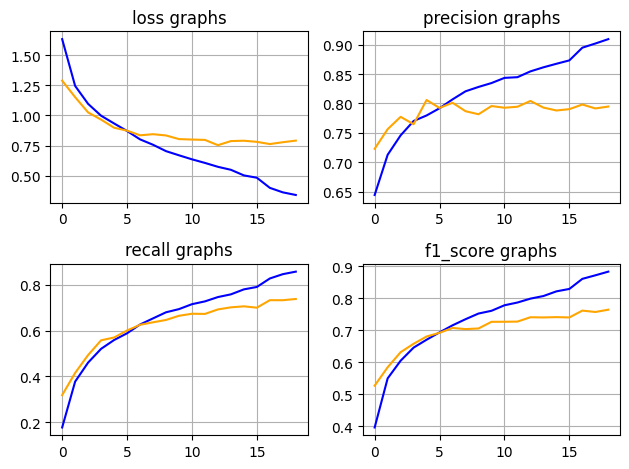

In [40]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(history_df['loss'], color='blue')
axs[0, 0].plot(history_df['val_loss'], color='orange')
axs[0, 0].set_title('loss graphs')
axs[0, 0].grid()
axs[0, 1].plot(history_df['precision_2'], color='blue')
axs[0, 1].plot(history_df['val_precision_2'], color='orange')
axs[0, 1].set_title('precision graphs')
axs[0, 1].grid()
axs[1, 0].plot(history_df['recall_2'], color='blue')
axs[1, 0].plot(history_df['val_recall_2'], color='orange')
axs[1, 0].set_title('recall graphs')
axs[1, 0].grid()
axs[1, 1].plot(history_df['f1_score'], color='blue')
axs[1, 1].plot(history_df['val_f1_score'], color='orange')
axs[1, 1].set_title('f1_score graphs')
axs[1, 1].grid()
fig.tight_layout()
plt.show()

In [41]:
preds = exp_2_model.predict(X_test, verbose=0)
preds = np.argmax(preds, axis=1)
y_test_idx = np.argmax(y_test, axis=1)
print(classification_report(y_test_idx, preds))

              precision    recall  f1-score   support

           0       0.86      0.76      0.81       208
           1       0.85      0.86      0.85       189
           2       0.74      0.63      0.68       199
           3       0.59      0.67      0.63       208
           4       0.72      0.78      0.75       196
           5       0.66      0.65      0.65       202
           6       0.87      0.83      0.85       214
           7       0.87      0.87      0.87       199
           8       0.80      0.89      0.84       194
           9       0.82      0.81      0.81       191

    accuracy                           0.77      2000
   macro avg       0.78      0.77      0.77      2000
weighted avg       0.78      0.77      0.77      2000



Заключение: Метрики при обучении на 50% датасета снизились незначительно в сравнении с полным набором данных. При этом для обучения потребовалось большее количество эпох, что логично из-за меньшего размера датасета (каждая эпоха содержит меньше итераций, т.к. батч сайз остался неизменным). Но стоит отметить, что обучение заняло меньшее количество времени (2,5 мин) в сравнении с первым экспериментом.

# Exp 3

Проведем эксперимент с предобученным бэкбоном и 10% датасетом

In [42]:
dataset_train_3 = dataset_train.shard(num_shards=10, index=0)

In [43]:
len(dataset_train_3)*256

5120

In [44]:
backbone.load_weights('../Weights/backbone')
backbone.weights

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 32) dtype=float32, numpy=
 array([[[[-3.21784541e-02, -5.65008931e-02,  8.69211480e-02,
            1.41900685e-02,  1.21502034e-01,  3.34839299e-02,
            2.43771020e-02, -6.43562376e-02,  1.12775296e-01,
           -9.95760784e-02, -2.61960477e-01, -9.18506384e-02,
            1.42031133e-01, -7.35143200e-02, -2.07712017e-02,
            3.37416232e-02,  1.31594077e-01,  5.72979869e-03,
           -5.06646112e-02,  2.37167031e-02,  3.98697406e-02,
           -1.38369247e-01, -1.05120584e-01,  1.51110113e-01,
           -4.01232652e-02, -6.15901090e-02,  2.08195671e-03,
            8.02023113e-02, -3.96554284e-02,  9.89580713e-03,
            1.15381680e-01, -1.26767650e-01],
          [ 1.13330647e-01,  3.63745056e-02,  7.82887489e-02,
           -1.42020985e-01, -7.61158764e-02,  8.85690376e-03,
           -6.25455752e-02,  3.36933546e-02,  1.50954321e-01,
            1.18205003e-01, -1.80235922e-01, -7.79197589e-02,
            

In [45]:
#Зададим наш классификатор
inputs = keras.Input(shape = (32,32,3))
x=backbone(inputs)
x=keras.layers.Flatten()(x)
x=keras.layers.Dense(1024, activation="relu", name='Dense_1')(x)
x=keras.layers.Dropout(0.3)(x)
x=keras.layers.Dense(2046, activation='relu', name='Dense_2')(x)
x=keras.layers.Dense(512, activation='relu', name='Dense_3')(x)
x=keras.layers.Dense(256, activation='relu', name='Dense_4')(x)
output=keras.layers.Dense(10, activation='softmax', name='Output')(x)

exp_3_model = keras.models.Model(inputs = inputs, outputs = output)
exp_3_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 model (Functional)          (None, 7, 7, 128)         52288     
                                                                 
 flatten_3 (Flatten)         (None, 6272)              0         
                                                                 
 Dense_1 (Dense)             (None, 1024)              6423552   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 Dense_2 (Dense)             (None, 2046)              2097150   
                                                                 
 Dense_3 (Dense)             (None, 512)               1048

In [46]:
exp_3_model.compile(keras.optimizers.legacy.Adam(0.0005), loss="categorical_crossentropy",
              metrics=[keras.metrics.F1Score(average = 'weighted'), 
                       keras.metrics.Precision(name='precision_3'), 
                       keras.metrics.Recall(name='recall_3')])

In [47]:
learn_rate_red=keras.callbacks.ReduceLROnPlateau("val_loss", patience=3, factor = 0.5, min_lr=1e-6)
early_stop = keras.callbacks.EarlyStopping("val_loss", patience=6)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="../logs/Exp_3")

In [48]:
%%time
history_3 = exp_3_model.fit(dataset_train_3, validation_data=dataset_valid, 
                    epochs=50, callbacks=[learn_rate_red, early_stop, tensorboard])

Epoch 1/50
20/20 [==============================] - 3s 107ms/step - loss: 2.0766 - f1_score: 0.2065 - precision_3: 0.5449 - recall_3: 0.0166 - val_loss: 1.7821 - val_f1_score: 0.3014 - val_precision_3: 0.5771 - val_recall_3: 0.0706 - lr: 5.0000e-04
Epoch 2/50
20/20 [==============================] - 2s 100ms/step - loss: 1.6996 - f1_score: 0.3703 - precision_3: 0.5900 - recall_3: 0.1107 - val_loss: 1.5528 - val_f1_score: 0.4337 - val_precision_3: 0.7077 - val_recall_3: 0.1350 - lr: 5.0000e-04
Epoch 3/50
20/20 [==============================] - 2s 118ms/step - loss: 1.5062 - f1_score: 0.4593 - precision_3: 0.6665 - recall_3: 0.2178 - val_loss: 1.4393 - val_f1_score: 0.4422 - val_precision_3: 0.6815 - val_recall_3: 0.2439 - lr: 5.0000e-04
Epoch 4/50
20/20 [==============================] - 3s 135ms/step - loss: 1.3901 - f1_score: 0.4922 - precision_3: 0.6782 - recall_3: 0.2947 - val_loss: 1.3916 - val_f1_score: 0.4875 - val_precision_3: 0.7258 - val_recall_3: 0.2399 - lr: 5.0000e-04
Epoc

Epoch 34/50
20/20 [==============================] - 2s 121ms/step - loss: 0.5551 - f1_score: 0.8128 - precision_3: 0.8675 - recall_3: 0.7609 - val_loss: 0.9086 - val_f1_score: 0.6936 - val_precision_3: 0.7556 - val_recall_3: 0.6403 - lr: 2.5000e-04
Epoch 35/50
20/20 [==============================] - 2s 121ms/step - loss: 0.5377 - f1_score: 0.8183 - precision_3: 0.8667 - recall_3: 0.7697 - val_loss: 0.9019 - val_f1_score: 0.6951 - val_precision_3: 0.7651 - val_recall_3: 0.6391 - lr: 2.5000e-04
Epoch 36/50
20/20 [==============================] - 2s 122ms/step - loss: 0.5268 - f1_score: 0.8211 - precision_3: 0.8757 - recall_3: 0.7734 - val_loss: 0.9037 - val_f1_score: 0.6994 - val_precision_3: 0.7650 - val_recall_3: 0.6505 - lr: 1.2500e-04
Epoch 37/50
20/20 [==============================] - 2s 123ms/step - loss: 0.5008 - f1_score: 0.8331 - precision_3: 0.8835 - recall_3: 0.7852 - val_loss: 0.8856 - val_f1_score: 0.7049 - val_precision_3: 0.7669 - val_recall_3: 0.6543 - lr: 1.2500e-04


In [49]:
eval_hist_3 = exp_3_model.evaluate(dataset_test)

8/8 [==============================] - 0s 38ms/step - loss: 0.8170 - f1_score: 0.7228 - precision_3: 0.7818 - recall_3: 0.6770


In [50]:
print("Eval_loss = {} \nEval_f1 = {} \nEval_precision = {} \nEval_recall = {}".format(eval_hist_3[0], 
                                                                                      eval_hist_3[1], 
                                                                                      eval_hist_3[2],
                                                                                      eval_hist_3[3]))

Eval_loss = 0.8170303702354431 
Eval_f1 = 0.7227534651756287 
Eval_precision = 0.7817552089691162 
Eval_recall = 0.6770000457763672


<Axes: >

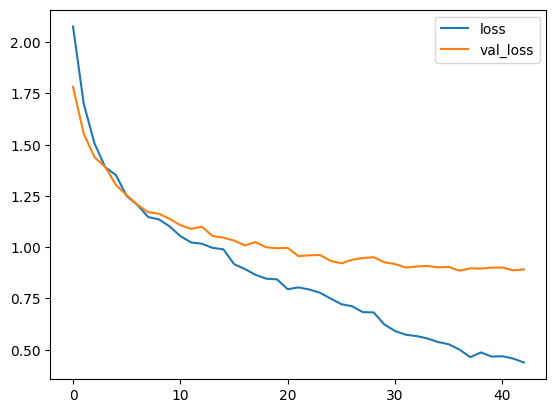

In [51]:
#График изменения функции потерь
history_df = pd.DataFrame(history_3.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

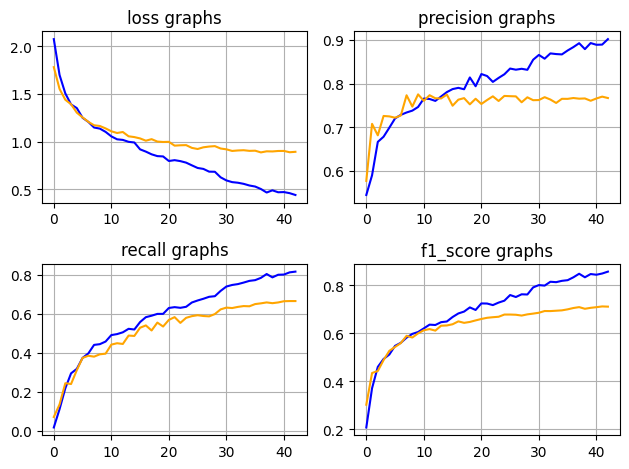

In [52]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(history_df['loss'], color='blue')
axs[0, 0].plot(history_df['val_loss'], color='orange')
axs[0, 0].set_title('loss graphs')
axs[0, 0].grid()
axs[0, 1].plot(history_df['precision_3'], color='blue')
axs[0, 1].plot(history_df['val_precision_3'], color='orange')
axs[0, 1].set_title('precision graphs')
axs[0, 1].grid()
axs[1, 0].plot(history_df['recall_3'], color='blue')
axs[1, 0].plot(history_df['val_recall_3'], color='orange')
axs[1, 0].set_title('recall graphs')
axs[1, 0].grid()
axs[1, 1].plot(history_df['f1_score'], color='blue')
axs[1, 1].plot(history_df['val_f1_score'], color='orange')
axs[1, 1].set_title('f1_score graphs')
axs[1, 1].grid()
fig.tight_layout()
plt.show()

In [53]:
preds = exp_3_model.predict(X_test, verbose=0)
preds = np.argmax(preds, axis=1)
y_test_idx = np.argmax(y_test, axis=1)
print(classification_report(y_test_idx, preds))

              precision    recall  f1-score   support

           0       0.74      0.79      0.76       208
           1       0.85      0.81      0.83       189
           2       0.69      0.56      0.62       199
           3       0.58      0.50      0.54       208
           4       0.67      0.72      0.69       196
           5       0.57      0.66      0.61       202
           6       0.82      0.75      0.78       214
           7       0.74      0.84      0.79       199
           8       0.84      0.81      0.83       194
           9       0.78      0.79      0.78       191

    accuracy                           0.72      2000
   macro avg       0.73      0.73      0.72      2000
weighted avg       0.73      0.72      0.72      2000



Заключение: В случае с использованием всего 10 процентов данных, значения метрик упали. При этом время обучения (1 мин 42 с) значительно меньше, чем при обучении на полном датасете.

# Вывод

Стоит отметить, что при использовании предобучения feature extractor удалось достичь схожих метрик с моделью из hw_1. При этом обучение заняло меньшее количество времени, что может быть существенно при решении более сложных задач.